## 感知机Perceporn

> 理论 《统计学习方法》第二章 感知机
> 
> 代码 numpy version && torch version
>
> Python3.7

In [10]:
%matplotlib inline

### 模型
二分类的线性分类模型，目的是找到一个超平面将所有实例**线性划分**为正例和负例，取值为$+1 -1$。属于是**判别模型**

输入空间到输出空间由以下函数进行定义
$$
f(x) = sign(w\cdot x + b)
$$

感知机是在特征空间中所有线性分类模型的**集合**（因为分离超平面不唯一）

### 策略

首先要求数据集线性可分，采用基于误分类点的损失，采用梯度下降法对损失函数进行极小化。

对于误分类的点，总是有$-y_i(w\cdot x_i + b) > 0$成立，该式子再乘上一个$1\over ||w||$（L2范式）就是误分类点到超平面的距离

将所有的误分类点到分离超平面的距离进行加总，然后不考虑前面的L2范数，就得到了感知机的损失函数
$$
Loss(w,b) =  - \Sigma_{x_i\in M} y_i(w\cdot x_i + b),M是误分类点集合
$$

Loss是非负的，因为没有误分类点时候Loss=0;误分类点越少,Loss越小。

此外，Loss是连续可导的。

### 算法

SGD

1. 原始形式
   
   求解$\min Loss(w,b)$，每一次随机选择一个误分类点来修正w,b。
   Loss关于w,b的梯度分别为
   $$
      \Delta_w Loss(w,b) = - \Sigma y_i x_i
      \\
      \Delta_b Loss(w,b) = - \Sigma y_i
   $$
   给定一个学习率$\eta$，对w,b进行更新，对每个误分类点(也就是有 $ y_i (w\cdot x_i + b)\le 0$成立)
   $$
      w = w + \eta y_i x_i
      \\
      b = b + \eta y_i
   $$
   迭代Loss不断减少，直到为0，则找到了一个分离超平面   


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random

In [12]:
x_train = np.array([[3.,3.],[4,3],[1,1]])
y_train = np.array([1,1,-1])

In [13]:
def sign(x):
    if x > 0:
        return 1
    else:
        return -1

In [14]:
def draw_fig(x,y,w,b):
    plt.figure(dpi=64,figsize=(4,4))

    # 正负实例的散点图，这儿使用了一个Bool索引，切片混合索引
    # plt.scatter(x[y==1][:,0],x[y==1][:,1],color='r')
    # plt.scatter(x[y==-1][:,0],x[y==-1][:,1],color='g')
    plt.scatter(x[:,0],x[:,1],c=y)

    # 画分离超平面
    x1 = np.arange(-1, 4, 0.1)
    x2 = (w[0] * x1 + b) / (-w[1])
    plt.plot(x1,x2)

    plt.show()

epoch 1 % w is [3. 3.],b is 1
epoch 2 % w is [2. 2.],b is 0
epoch 3 % w is [1. 1.],b is -1
epoch 4 % w is [0. 0.],b is -2
epoch 5 % w is [3. 3.],b is -1
epoch 6 % w is [2. 2.],b is -2
epoch 7 % w is [1. 1.],b is -3

finally get w is [1. 1.], b is -3


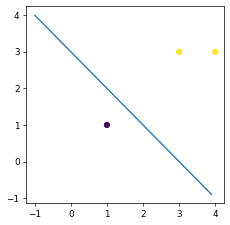

In [15]:
# 定义超参
lr = 1
w = np.zeros(x_train.shape[1])
b = 0
epoch = 1

flag = True
while flag:
    label = np.zeros_like(y_train)
    for i,v in enumerate(x_train):
        y_hat = (v*w).sum() + b
        if sign(y_hat) != y_train[i]:
            w = w + lr * v * y_train[i]
            b = b + lr * y_train[i]
            print("epoch {} % w is {},b is {}".format(epoch,w,b))
            epoch += 1
        label[i] = sign(y_hat)
    if (label == y_train).all():
        flag = False

print("\nfinally get w is {}, b is {}".format(w,b))

draw_fig(x_train,y_train,w,b)

In [16]:
class Perception(nn.Module):
    def __init__(self,n):
        super(Perception,self).__init__()
        self.w = nn.Parameter(torch.ones((n,1)))
        self.b = nn.Parameter(torch.zeros((1,1)))

    def forward(self,x):
        pred = torch.mm(x,self.w) + self.b
        pred = torch.sign(pred)
        return pred

    def loss_func(self,x,y):
        return -y * (torch.mm(x,self.w)+ self.b).squeeze()

    def init_param(self):
        for name,param in self.named_parameters():
            nn.init.kaiming_uniform_(param)

def SGD_optimizer(net,input_x,label):
    y_pred = net(input_x)
    y_pred = y_pred.squeeze()
    non_zero = torch.nonzero(torch.eq(y_pred,label)).squeeze(1)
    index = (set(range(len(label))) - set(non_zero.tolist()))
    if len(index) == 0:
        return -1,-1
    index = list(index)

    index = random.choice(index)
    loss = net.loss_func(input_x[index].unsqueeze(0),label[index])
    return loss, 0

Done!

finally get w is [-0.8050575  3.1798725], b is [-5.560445]


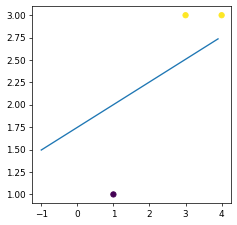

In [17]:
x = torch.from_numpy(x_train)
x = x.float()
y = torch.from_numpy(y_train)
y = y.float()

model = Perception(len(x[0]))
model.init_param()
lr = 1
while True:
    loss, _ = SGD_optimizer(model, x, y)
    if _ == -1:
        print('Done!')
        break

    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            # print(param.grad)
            param -= param.grad * lr

w = model.w.data.numpy()[:,0]
b = model.b.data.numpy()[0]
print("\nfinally get w is {}, b is {}".format(w,b))

draw_fig(x_train,y_train,w,b)

2. 对偶形式
   
   将w,b表示为实例$(x_i,y_i)$的线性组合，来进行求解

   与原始形式相比，将w,b都初始化为0,令$\alpha_i = \eta_i\ \eta$,就可以将w,b表示为
   $$
   w =  \Sigma \alpha_i y_i x_i
      \\
      b = \Sigma \alpha_i y_i
   $$

   对偶形式的输出为$\alpha = {(\alpha_1,..,\alpha_N)^T}$,$b$。
   
   在训练数据集中选择$(x_i.y_i)$，若满足$y_i(\Sigma_{j=1}^N \alpha_j y_j x_j \cdot x_i + b) \le 0$。则更新$\alpha_i = \alpha_i + \eta, b = b + \eta y_i$。
   
   一直到没有误分类点


   $$
        \Sigma_{j=1}^N \alpha_j y_j x_j \cdot x_i = \Sigma_{j=1}^N \alpha_j y_j G[j,i]
   $$

epoch 1 : alpha is [1. 0. 0.],b is 1
epoch 2 : alpha is [1. 0. 1.],b is 0
epoch 3 : alpha is [1. 0. 2.],b is -1
epoch 4 : alpha is [1. 0. 3.],b is -2
epoch 5 : alpha is [2. 0. 3.],b is -1
epoch 6 : alpha is [2. 0. 4.],b is -2
epoch 7 : alpha is [2. 0. 5.],b is -3

finally get alpha is [2. 0. 5.], b is -3

finally get w is [1. 1.], b is -3


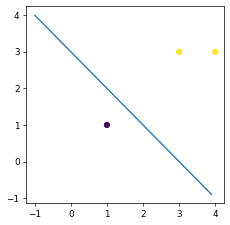

In [18]:
Gram = np.dot(x_train,x_train.T)

# 定义超参
lr = 1
alpha = np.zeros(x_train.shape[0])
b = 0
epoch = 1

flag = True
while flag:
    label = np.zeros_like(y_train)
    for i in range(len(x_train)):
        sum = 0
        for j in range(len(x_train)):
            sum += alpha[j] * y_train[j] * Gram[j][i]
        y_hat = sum + b
        if sign(y_hat) != y_train[i]:
            alpha[i] += lr
            b += lr * y_train[i]
            print("epoch {}: alpha is {},b is {}".format(epoch,alpha,b))
            epoch += 1
        label[i] = sign(y_hat)
    if (label == y_train).all():
        flag = False

print("\nfinally get alpha is {}, b is {}".format(alpha,b))

w = np.zeros(x_train.shape[1])
for i in range(len(alpha)):
    for j in range(len(w)):
        w[j] += alpha[i] * label[i] * x_train[i][j]
        
print("\nfinally get w is {}, b is {}".format(w,b))
draw_fig(x_train,y_train,w,b)